In [3]:
# Saudi News Articles Analysis and Classification 

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from plotnine import *
from glob import glob
import numpy as np 
import arabicstopwords.arabicstopwords as stp
import missingno as msno
import re
from camel_tools.sentiment import SentimentAnalyzer
import nltk 
from nltk.stem.snowball import SnowballStemmer
import unicodedata
from textblob_ar import TextBlob as tb
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from collections import Counter


In [5]:
#Download Arabic stopwords from NLTK 
#nltk.download()
nltk.download("stopwords")
arabic_stopwords_list = set(nltk.corpus.stopwords.words("arabic"))
stemmer = SnowballStemmer("arabic")
sentiment = SentimentAnalyzer.pretrained()
detokenizer = Detok()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AlaAlBinSaleh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
arabic_stopwords_list.update(["فى","في","كل","لم","لن","له""من","هو","هي","قوة","كما","لها",'منذ',"وقد",'ولا',
"نفسه","لقاء","مقابل","هناك","وقال","وكان","نهاية","وقالت","وكانت","للامم","فيه",
"كلم","لكن","وفي","وقف","ولم","ومن","وهو","وهي","يوم","فيها","منها","مليار",
"لوكالة","يكون","يمكن","مليون","حيث","اكد","الا","اما","امس","السابق","التى","التي",
"اكثر","ايار","ايضا","ثلاثة","الذاتي","الاخيرة","الثاني","الثانية","الذى","الذي","الان",
"امام","ايام","خلال","حوالى","الذين","الاول","الاولى","بين","ذلك","دون","حول","حين","الف",
"الى","انه","اول","ضمن","انها","جميع","الماضي","الوقت","المقبل","اليوم","ـ","ف",
"و","و6","قد","لا","ما","مع","مساء","هذا","واحد","واضاف","واضافت","فان","قبل","قال","كان",
"لدى","نحو","هذه","وان","واكد","كانت","واوضح","مايو","ب","ا","أ","،","عشر","عدد","عدة","عشرة",
"عدم","عام","عاما","عن","عند","عندما","على","عليه","عليها","زيارة","سنة","سنوات","تم","ضد","بعد",
"بعض","اعادة","اعلنت","بسبب","حتى","اذا","احد","اثر","برس","باسم","غدا","شخصا","صباح","اطار",
"اربعة","اخرى","بان","اجل","غير","بشكل","حاليا","بن","به","ثم","اف","ان","او","اي","بها","صفر"
"أنه","بأن"])

In [6]:
files_list = glob('news_*')

dfs = [] 
for file in files_list:
    data = pd.read_json(file) 
    dfs.append(data) 

ArNews_df = pd.concat(dfs, ignore_index=True)

In [7]:
ArNews_df.head()

,source,url,date_extracted,title,author,content
0,3alyoum,http://www.3alyoum.com/news/local/a/صور-فاضحة-...,2015-08-08 06:30:06,صور فاضحة مع فتيات في لوس أنجلوس تحيل 3 قياديي...,,عين اليوم – متابعات\nأحالت أمانة منطقة المدين...
1,3alyoum,http://www.3alyoum.com/news/golobal/a/قتيل-وجر...,2015-08-08 06:30:11,قتيل وجرحى بهجوم مسلح على حافلة إيرانية في تركيا,,عين اليوم – متابعات\nقتل شخص وجرح 3 آخرين بهج...
2,3alyoum,http://www.3alyoum.com/news/local/a/مدنى-دومة-...,2015-08-08 06:30:16,مدنى دومة الجندل يسيطر على حريق في مزارع بعين ...,,رواف الكويكبي _ عين اليوم\n قال المتحدث الرسم...
3,3alyoum,http://www.3alyoum.com/news/pol/a/مظاهرات-واسع...,2015-08-08 06:30:19,مظاهرات واسعة في العراق ضد الفساد,,عين اليوم – بغداد\nدعا المرجع الشيعي الأعلى ف...
4,3alyoum,http://www.3alyoum.com/news/local/a/جثمان-الشه...,2015-08-08 06:30:22,جثمان الشهيد الحارثي يصل الطائف والصلاة عليه ظ...,,نايف السعدي – عين اليوم\n قال الناطق الإعلامي...


In [8]:
ArNews_df.isnull().values.any()

False

In [9]:
ArNews_df = ArNews_df.replace(r'^\s*$', np.nan, regex=True)

# dealing with missing values: 
ArNews_df.isnull().sum()

source               0
url                  0
date_extracted       0
title               67
author            4736
content            354
dtype: int64

<AxesSubplot:>

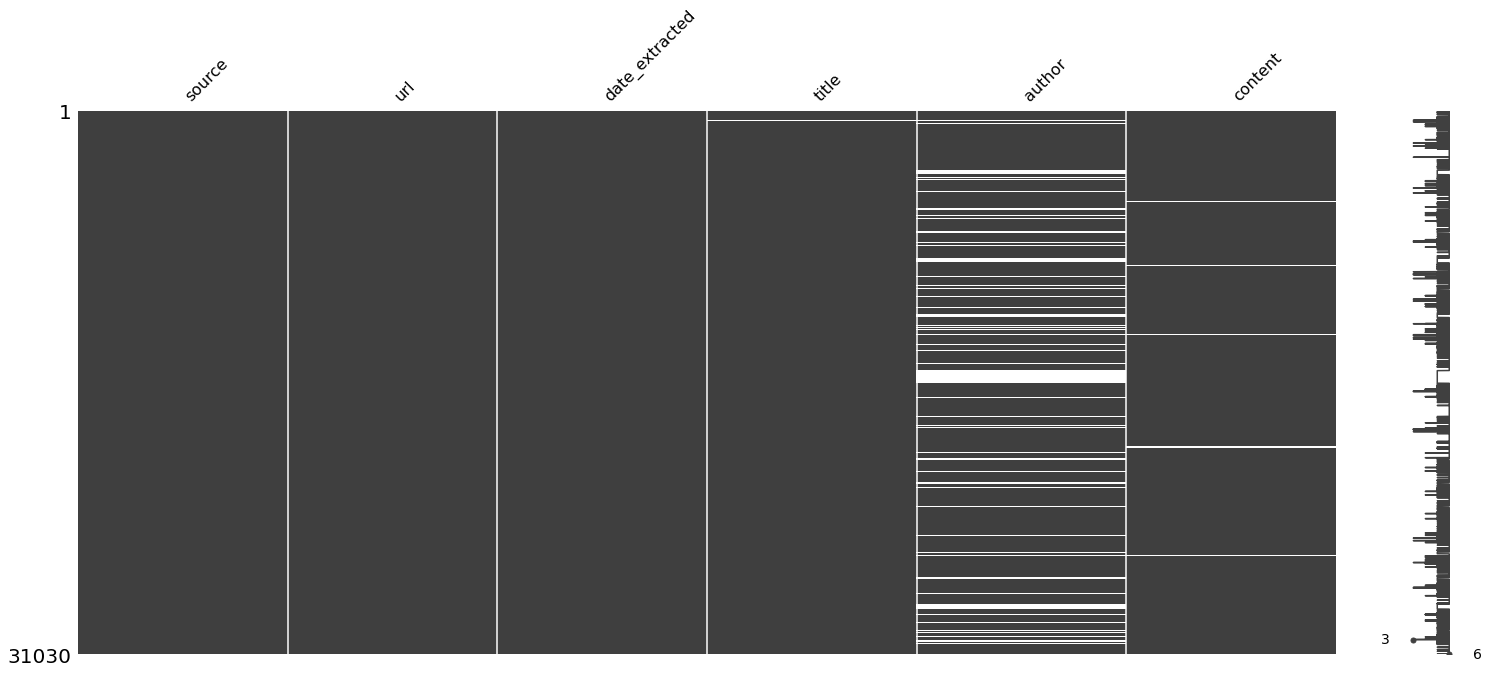

In [10]:
msno.matrix(ArNews_df)

In [11]:
ArNews_df = ArNews_df[ArNews_df.content.isnull() == False]
ArNews_df = ArNews_df[ArNews_df.author.isnull() == False]
ArNews_df = ArNews_df[ArNews_df.title.isnull() == False]
#reset index 
ArNews_df = ArNews_df.reset_index(drop=True)

ArNews_df.content.isnull().any() #false 

False

In [12]:
# Removing unwanted characters and stop words  
#remove punctuation 
p = re.compile(r'[^\w\s]+')
ArNews_df['content'] = [p.sub('', x) for x in ArNews_df['content'].tolist()]

#remove \n from the content 
ArNews_df['content'] = ArNews_df.content.str.replace("\xa0","") 
ArNews_df['content'] = ArNews_df.content.str.replace("\n"," ")
ArNews_df['content'] = ArNews_df.content.str.replace("_ ","")
ArNews_df['content'] = ArNews_df.content.str.replace("- ","")
ArNews_df['content'] = ArNews_df.content.str.replace(":","")
ArNews_df['content'] = ArNews_df.content.str.replace("»","")
ArNews_df['content'] = ArNews_df.content.str.replace("«","")

#remove strings connected to symbols    
ArNews_df['content'] = ArNews_df.content.str.replace("سبق","")
ArNews_df['content'] = ArNews_df.content.str.replace("سبق-","")
ArNews_df['content'] = ArNews_df.content.str.replace("- -","")

#remove digits/numbers  
ArNews_df['content'] = ArNews_df['content'].str.replace('\d+', '')

# remove parentheses () and data inside them 
ArNews_df["content"] = ArNews_df["content"].str.replace(r" \(.*\)","")


/var/folders/1q/17wbd_xs3c358lsfdpvlg3lr0000gn/T/ipykernel_3228/3804166305.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
/var/folders/1q/17wbd_xs3c358lsfdpvlg3lr0000gn/T/ipykernel_3228/3804166305.py:24: FutureWarning: The default value of regex will change from True to False in a future version.


In [13]:
#fix the source/news paper names just because 
ArNews_df['source'] = ArNews_df.source.str.replace("aawsat","Al Sharq Al Awsat")
ArNews_df['source'] = ArNews_df.source.str.replace("aleqtisadiya","Al Eqtisadiya")
ArNews_df['source'] = ArNews_df.source.str.replace("aljazirah","Al Jazirah")
ArNews_df['source'] = ArNews_df.source.str.replace("almadina","Al Madina")
ArNews_df['source'] = ArNews_df.source.str.replace("alriyadh","Al Riyadh")
ArNews_df['source'] = ArNews_df.source.str.replace("alwatan","Al Watan")
ArNews_df['source'] = ArNews_df.source.str.replace("alweeam","Al Weeam")
ArNews_df['source'] = ArNews_df.source.str.replace("alyaum","Al Yaum")
ArNews_df['source'] = ArNews_df.source.str.replace("okaz","Okaz")
ArNews_df['source'] = ArNews_df.source.str.replace("sabq","Sabq")
ArNews_df['source'] = ArNews_df.source.str.replace("arreyadi","Arreyadi")
ArNews_df['source'] = ArNews_df.source.str.replace("arriyadiyah","Arriyadiyah")

#author column cleaning 
ArNews_df['author'] = [p.sub('', x) for x in ArNews_df['author'].tolist()]
ArNews_df['author'] = ArNews_df.author.str.replace("سبق","")
ArNews_df['author'] = ArNews_df.author.str.replace("واس","")
ArNews_df['author'] = ArNews_df.author.str.replace("\xa0","")

In [14]:
ArNews_df['words_before_stop'] = ArNews_df["content"].apply(nltk.word_tokenize)

In [15]:
#remove stop words 
ArNews_df['words_after_stop']= ArNews_df['words_before_stop'].apply(lambda x: [item for item in x if item not in arabic_stopwords_list])

In [16]:
#number of words before and after stop words removal 
ArNews_df['word_count_stop'] = ArNews_df['words_before_stop'].str.len() #before 
ArNews_df['word_count_wo_stop'] = ArNews_df['words_after_stop'].str.len() #after 

In [17]:
#stemming 
#ArNews_df['words_before_stop'] = ArNews_df['Words_before_stop'].apply(lambda x: [stemmer.stem(y) for y in x])
ArNews_df['words_stem'] = ArNews_df['words_before_stop'].apply(lambda x: [stemmer.stem(y) for y in x])
#ArNews_df.apply(lambda row: nltk.word_tokenize(row["verbatim"]), axis=1)


In [18]:
#Remove short articles 
ArNews_df = ArNews_df[ArNews_df.word_count_stop > 20]

In [19]:
# News Source vs Content 
Source_Content = ArNews_df.groupby(['source'])["content"].count().sort_values(ascending=True)
pd.DataFrame(Source_Content)

,content
source,
Arriyadiyah,50
Arreyadi,82
Sabq,1386
Al Madina,1957
Al Weeam,2033
Al Watan,2107
Al Sharq Al Awsat,2602
Okaz,2703
Al Eqtisadiya,2733


Text(0.5, 1.0, 'Number of Articles Based on Their Source')

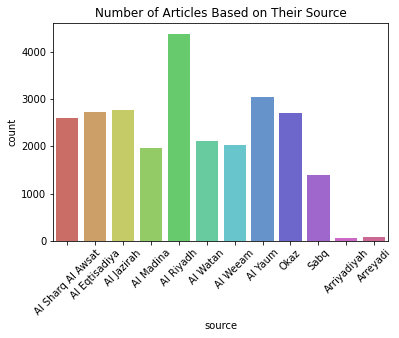

In [20]:
# plot the 
sns.countplot(x="source", 
              data=ArNews_df,
              palette =sns.color_palette("hls", 12)
            )
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 10})
plt.title("Number of Articles Based on Their Source")

Insight: 
Al Riyadh has the most articles in this data are. since, it is one of the leading news platform in KSA 
While the Arriyadi has the least number of aricles . 

Check what topics does it cover based keywords 

Text(0.5, 1.0, 'Words count distribution before and after stop words removal')

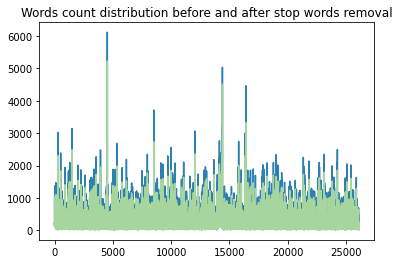

In [21]:
plt.plot(ArNews_df.word_count_stop, color='#2D80B2')
plt.plot(ArNews_df.word_count_wo_stop, color='#A6D59E')
plt.title("Words count distribution before and after stop words removal")

Insight: 
most articles had drop in words count except for 4 articles when are already small in size  

In [ ]:
#detokenize 
ArNews_df['Detokenize'] = ArNews_df["words_after_stop"].apply(detokenizer.detokenize)

#find the most frequent words 
Top_words = Counter(" ".join(ArNews_df["Detokenize"]).split()).most_common(50)
words = [t for t,n in Top_words]
frequency = [n for t,n in Top_words]
Top_words_df = pd.DataFrame({'words': words,'frequency': frequency})

#plot of the top 50 words 
sns.barplot(x="frequency", y="words", data=Top_words_df)
sns.set(rc = {'figure.figsize':(20,8)})
plt.title("Top 100 Frequent Words")

Insight: 
the word "الله" / "Allah" is the most frequent word used in the articles . 

In [ ]:
#Sentiment Analysis 
sentiment = SentimentAnalyzer.pretrained()

def Sentiment_analysis(text):
  try:
    return TextBlob(text).sentiment
  except:
    return None

a = ArNews_df["content"].apply(Sentiment_analysis)